In [6]:
import jax.numpy as jnp
from utils import apply_z_score
from kernels import RBF
from uci_datasets import Dataset


# load data
dataset = Dataset("yacht")
x_train, y_train, x_test, y_test = dataset.get_split(0)
N, D = x_train.shape
T = x_test.shape[0]
# convert to jax and apply z-score normalization
x_train, mu_x, sigma_x = apply_z_score(jnp.array(x_train))
y_train, mu_y, sigma_y = apply_z_score(jnp.array(y_train.squeeze()))
x_test = apply_z_score(jnp.array(x_test), mu=mu_x, sigma=sigma_x)
y_test = apply_z_score(jnp.array(y_test.squeeze()), mu=mu_y, sigma=sigma_y)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(mu_x.shape, sigma_x.shape, mu_y.shape, sigma_y.shape)
# compute kernel matrix
K = RBF(x_train, x_train)
print(K.shape)


yacht dataset, N=308, d=6
(278, 6) (278,) (30, 6) (30,)
(6,) (6,) () ()
(278, 278)


In [19]:
from linear_model import exact_solution, predict
from utils import RMSE

# compute exact solution
alpha_exact = exact_solution(y_train, K)
y_pred_exact = predict(alpha_exact, x_test, x_train, RBF)
test_rmse_exact = RMSE(y_pred_exact, y_test, mu=mu_y, sigma=sigma_y)
print(test_rmse_exact)

1.0136911


In [28]:
import jax
import jax.random as random
import optax
from linear_model import error, regularizer
from tqdm import tqdm


key = random.PRNGKey(12345)
key, subkey = random.split(key)
alpha = random.normal(subkey, shape=(N,))

learning_rate = 1e-4
momentum = .9
polyak_step_size = 1e-2
iterations = int(1e5)

optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum, nesterov=True)
opt_state = optimizer.init(alpha)


@jax.jit
def loss_fn(params):
    return error(params, y_train, K) + regularizer(params, K)


@jax.jit
def update(opt_state, params):
    loss, grad = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.incremental_update(optax.apply_updates(params, updates), params, step_size=polyak_step_size)
    return opt_state, params, loss


loss_trace = []
alpha_rmse_trace = []
test_rmse_trace = []

iterator = tqdm(range(iterations))
for i in iterator:
    opt_state, alpha, loss = update(opt_state, alpha)
    y_pred = predict(alpha, x_test, x_train, RBF)

    loss_trace.append(loss.item())
    alpha_rmse_trace.append(RMSE(alpha_exact, alpha).item())
    test_rmse_trace.append(RMSE(y_pred, y_test, mu=mu_y, sigma=sigma_y))


100%|██████████| 100000/100000 [02:19<00:00, 714.94it/s]


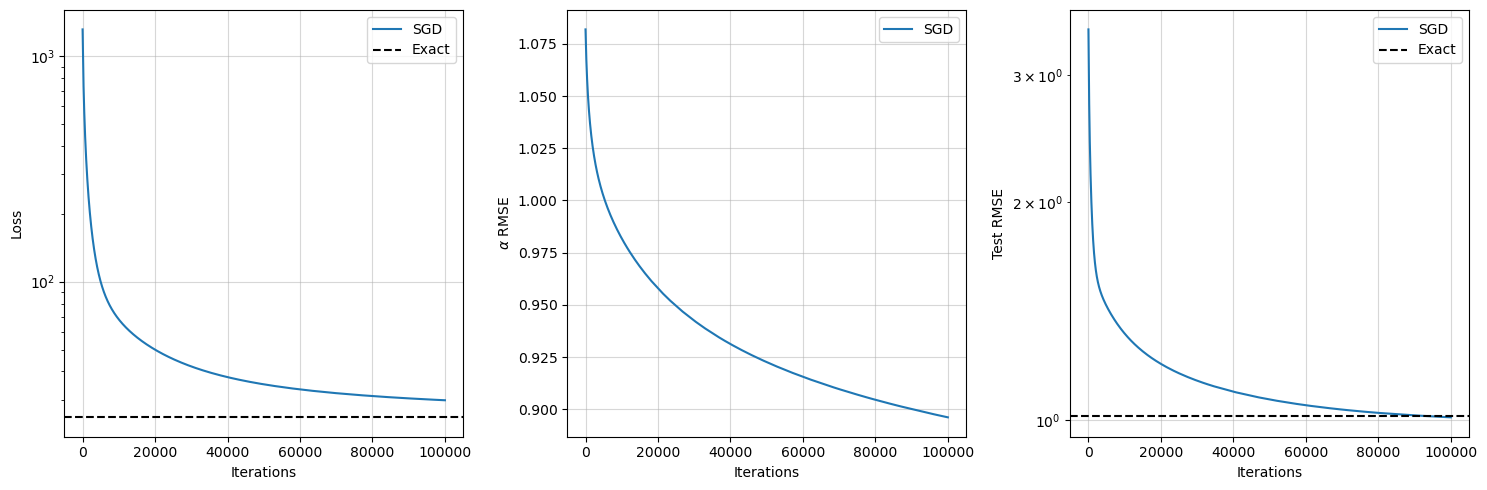

In [32]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=[15, 5])
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(loss_trace, color='tab:blue', label='SGD')
ax1.axhline(loss_fn(alpha_exact), color='k', linestyle='--', label='Exact')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.semilogy()
ax1.grid(alpha=.5)
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(alpha_rmse_trace, color='tab:blue', label='SGD')
ax2.set_xlabel("Iterations")
ax2.set_ylabel(r"$\alpha$ RMSE")
#ax2.semilogy()
ax2.grid(alpha=.5)
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(test_rmse_trace, color='tab:blue', label='SGD')
ax3.axhline(test_rmse_exact, color='k', linestyle='--', label='Exact')
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Test RMSE")
ax3.semilogy()
ax3.grid(alpha=.5)
ax3.legend()

fig.tight_layout()